# Pulsar detection 

## Introduction
### Background information

A pulsar is a celestial body which emits precise amounts of electromagnetic radiation. It is highly sought after by astrophysicists as it is the only place where they can observe matter indirectly at nuclear density.



### Question?


Can we build an accurate classifier to distinguish pulsars from other celestial bodies solely based on data gathered from DM_SNR curve (signal to noise ratio)?



### Dataset

The utilized dataset is [HTRU2 Data Set](https://archive.ics.uci.edu/ml/datasets/HTRU2) collected by Dr Robert Lyon, University of Manchester. 

## Preliminary exploratory data analysis:

In [28]:
# loading dependencies
library(tidyverse)
library(tidymodels)

**1. Showing that the data can be read and tidying the data**

In [ ]:
# loading the data
pulsarData <- read_csv("HTRU_2.csv", col_names = FALSE)

colnames(pulsarData) <- c("MeanIntegratedprofile", # X1
                           "SdIntegratedProfile",   # X2
                           "ExcessKurtosisIntegratedProfile", # X3
                           "SkewnessIntegratedProfile", #X4
                           "MeanDM_SNRcurve", # X5
                           "SdDM_SNRcurve",  #X6
                           "ExcessKurtosisDM_SNRcurve", #X7
                           "SkewnessDM_SNRcurve", #X8
                           "Class") #X9
pulsarData = mutate(pulsarData, Class = as.factor(Class))

**2. Dividing the data into training data and validating data**

In [29]:
pulsarSplit <- initial_split(pulsarData, prop = 0.75, strata = Class)
pulsarTrain <- training(pulsarSplit)
pulsarTesting <- testing(pulsarSplit)

**3. Summarize the data in at least one table**

Chosen features: Mean, SD, ExcessKurtosis and Skrewness of Integrated profile (Column 1, 2, 3, 4 respectively)

In [35]:
pulsarTrain %>% group_by(Class) %>% summarize(Count = n(), 
                                              IQRMeanIntegratedprofile = IQR(MeanIntegratedprofile), 
                                              MedianSdIntegratedprofile = mad(SdIntegratedProfile), 
                                              MeanExcessKurtosisIntegratedProfile = mean(ExcessKurtosisIntegratedProfile),
                                              SkewnessIntegratedProfile = mean(SkewnessIntegratedProfile))

Class,Count,IQRMeanIntegratedprofile,MedianSdIntegratedprofile,MeanExcessKurtosisIntegratedProfile,SkewnessIntegratedProfile
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
0,12204,23.17578,5.888683,0.2100362,0.3849501
1,1219,48.05859,8.275840,3.1326965,15.6158373


**4. visualize the data (TO BE COMPLETED)**

By Observe all relationships between each varialibles, we focus on Mean, SD, ExcessKurtosis and Skrewness of Integrated profile.

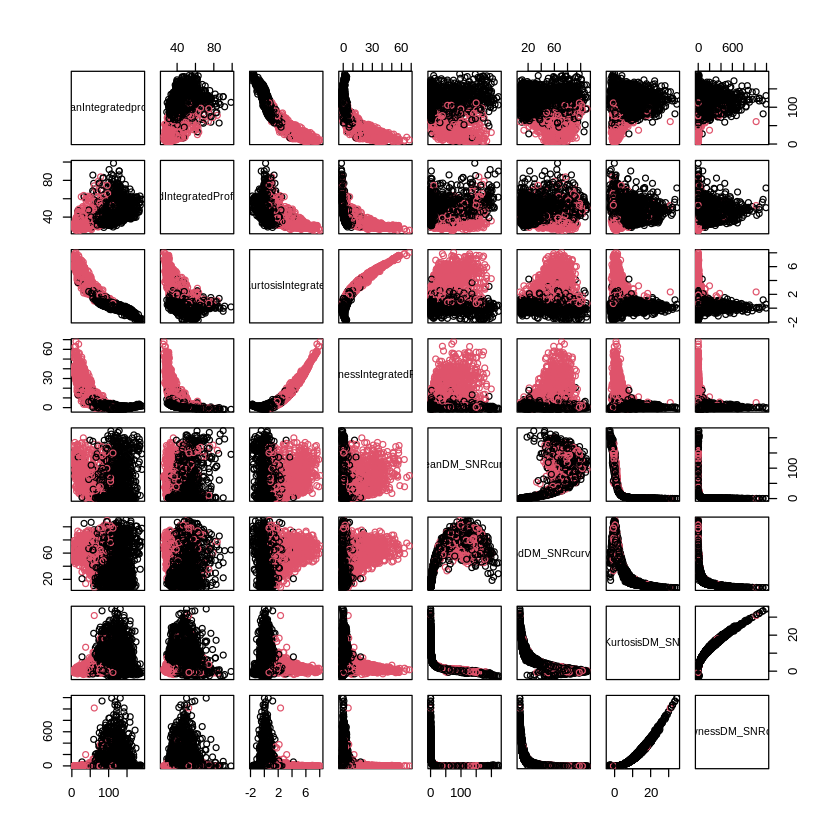

In [36]:
plot(pulsarTrain[1:8], col= pulsarTrain$Class)

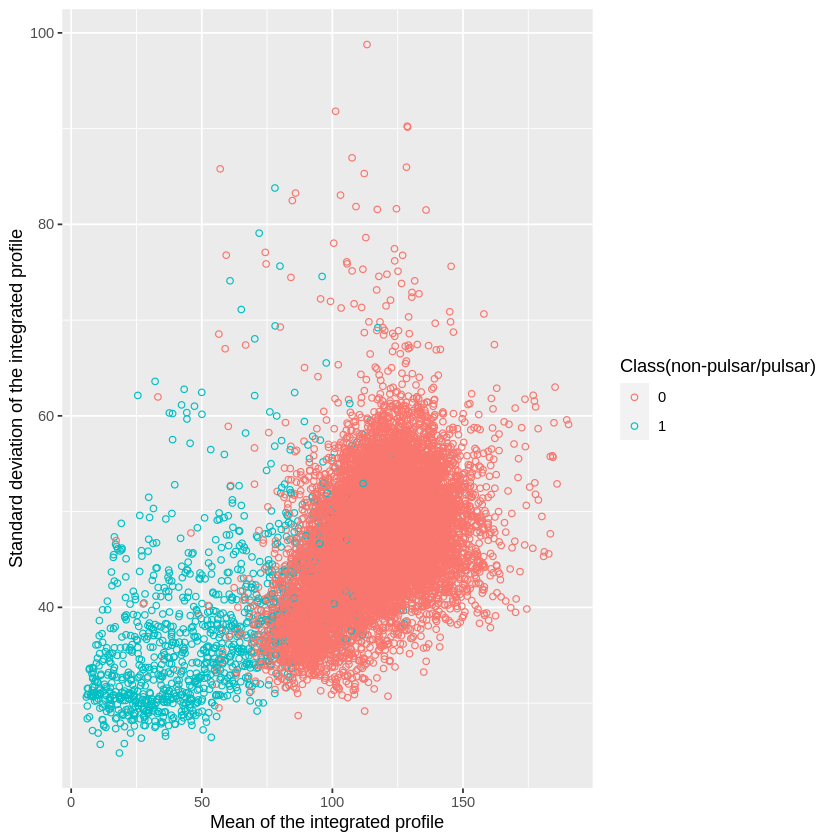

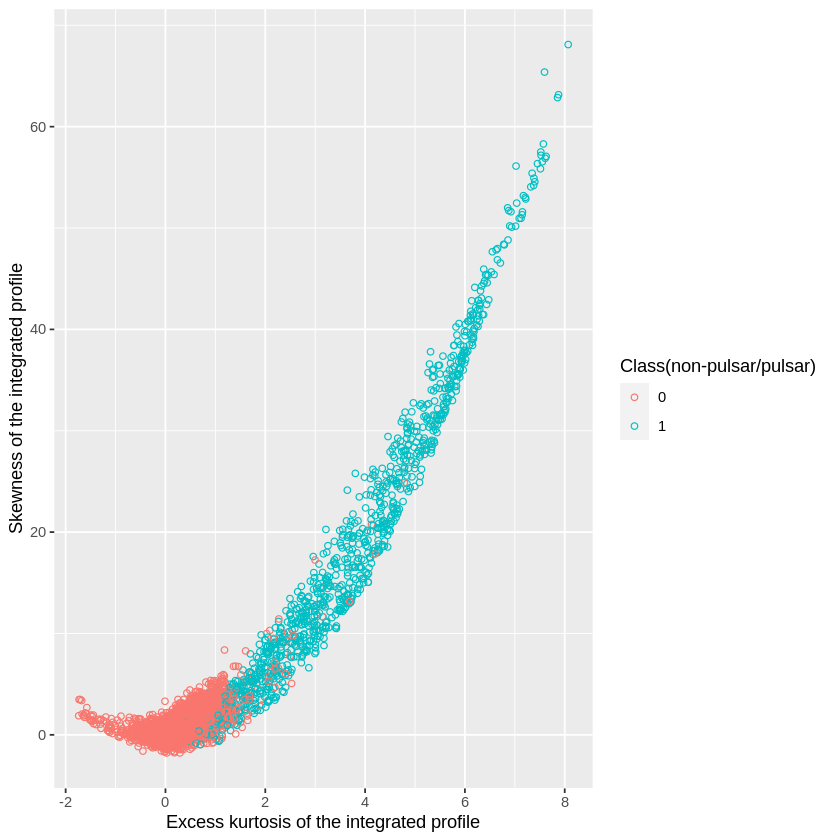

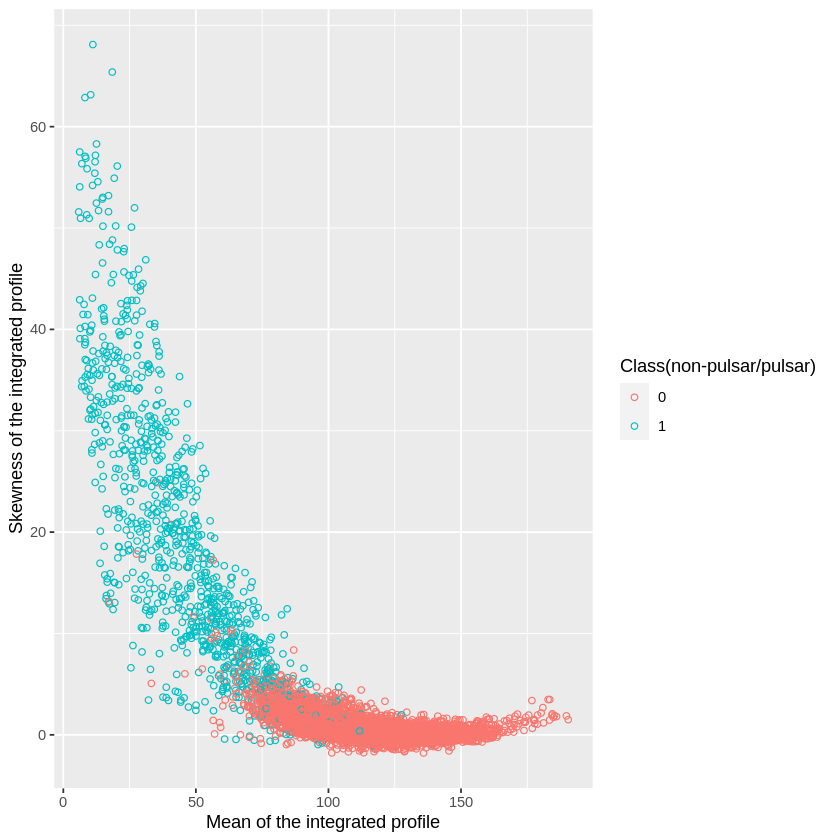

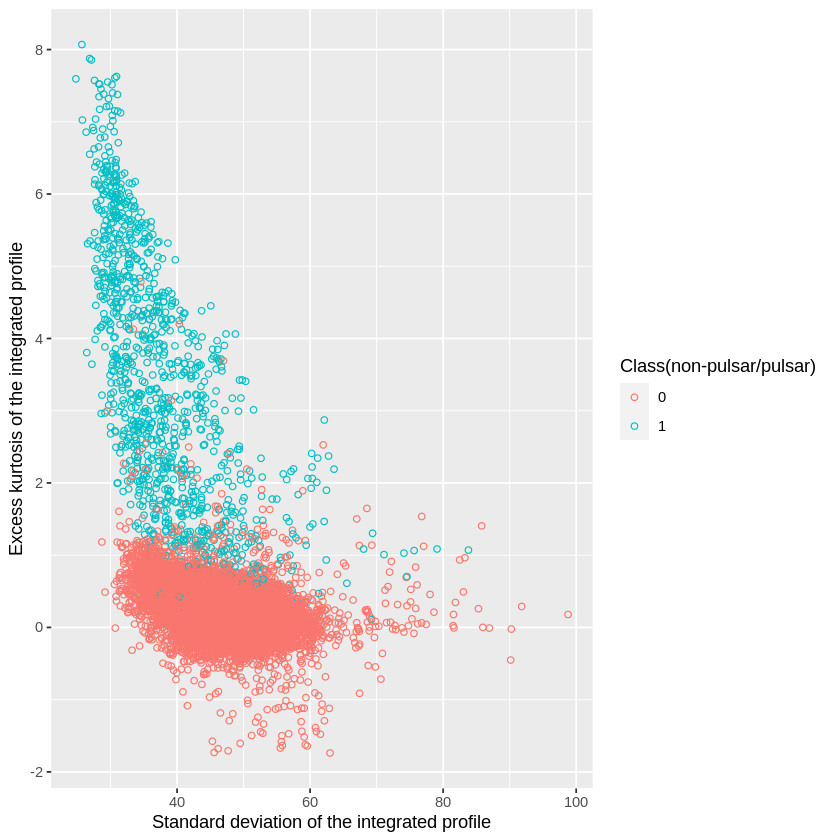

In [37]:
p1 <- pulsarTrain |>
        ggplot(aes( x = MeanIntegratedprofile, y = SdIntegratedProfile, col = Class)) +
        geom_point(shape = 1) +
        labs(x = "Mean of the integrated profile", y = "Standard deviation of the integrated profile", col = "Class(non-pulsar/pulsar)")
p1

p2 <- pulsarTrain |>
        ggplot(aes( x = ExcessKurtosisIntegratedProfile, y = SkewnessIntegratedProfile, col = Class)) +
        geom_point(shape = 1) +
        labs(x = "Excess kurtosis of the integrated profile", y = "Skewness of the integrated profile", col = "Class(non-pulsar/pulsar)")
p2

p3 <- pulsarTrain |>
        ggplot(aes( x = MeanIntegratedprofile, y = SkewnessIntegratedProfile, col = Class)) +
        geom_point(shape = 1) +
        labs(x = "Mean of the integrated profile", y = "Skewness of the integrated profile", col = "Class(non-pulsar/pulsar)")
p3

p3 <- pulsarTrain |>
        ggplot(aes( x =SdIntegratedProfile, y = ExcessKurtosisIntegratedProfile, col = Class)) +
        geom_point(shape = 1) +
        labs(x = "Standard deviation of the integrated profile", y = "Excess kurtosis of the integrated profile", col = "Class(non-pulsar/pulsar)")
p3

## Methods (TO BE COMPLETED)
### Explain how you will conduct either your data analysis and which variables/columns you will use (MUST BE RECHECKED)
Classification will be used in to determine if radiation detected from a celestial body can be categorized as a pulsar. The data from integrated profiles will be used as features. ***The columns to be used are the following: MeanIntegratedProfile, SdIntegratedProfile, ExcessKurtosisIntegratedProfile, SkewnessIntegratedProfile.***

### Describe at least one way that you will visualize the results (TO BE COMPLETED)


## Expected outcomes and significance:
### What do you expect to find?
We expect to separate this data into training and testing data to test the training data's accuracy and compare it to our testing data to improve its overall performance when a new observation is detected during this period. And hopefully have the outcome of high accuracy to detect new observations of pulsar stars in our plot based on our variables filtered and selected and find the relations between them, which would figure out the best k=value for further detection of new inspection.
### What impact could such findings have?
It will benefit the study of physics and enhance the navigation of the universe using the
radiation emitted from the detector, and later can be used to calculate the precise
space position.

### What future questions could this lead to?
Knowing the locations of stars to be able for future scientists to examine this data to enhance the research of outer space exploration with more precise calculations of distance which will, in the future, lead to the upgraded technology of space travelling.